In [140]:
from scipy.signal import find_peaks, savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import uniform_filter1d
from math import atan, degrees, radians
import matplotlib.pyplot as plt
from scipy import interpolate
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [141]:
def load_data(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def find_R_peaks(signal, channel=0, sample_freq=500, to_filter=False, seq_len=-1, check_streak=7):
    # Проблема такого метода: разная ориентация по ЭОС

    if seq_len == -1:
        channeled_signal = signal[channel]
    else:
        channeled_signal = signal[channel][0:seq_len]


    if to_filter:
        channeled_signal = nk.ecg_clean(channeled_signal, sampling_rate=sample_freq)
    
    streak = 0
    p_peaks = []
    heart_rate = []
    for i in range(1, len(channeled_signal)):
        if atan((abs(channeled_signal[i] - channeled_signal[i-1]))*sample_freq) > radians(85):
            streak = streak + 1
            if channeled_signal[i] - channeled_signal[i-1] < 0:
                if streak > check_streak:
                    p_peaks.append(i)
                    if len(p_peaks) > 1:
                        heart_rate.append(p_peaks[len(p_peaks) - 1] - p_peaks[len(p_peaks) - 2])

                streak = 0
        else:
            if streak > check_streak:
                p_peaks.append(i)
                if len(p_peaks) > 1:
                    heart_rate.append(p_peaks[len(p_peaks) - 1] - p_peaks[len(p_peaks) - 2])

            streak = 0

    
    return p_peaks, heart_rate

def visualize_channel_with_peaks(signal, peaks, sample_freq=500, channel=0, to_filter=False, seq_len=-1):
    ecg_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    plt.rcParams['figure.figsize'] = [14, 4]

    plt.title(ecg_order[channel])

    signal_ = signal[channel]

    if to_filter:
        signal_ = nk.ecg_clean(signal_, sampling_rate=sample_freq)

    if seq_len == -1:
        plt.plot(signal_)
    else:
        plt.plot(signal_[0:seq_len])

    plt.title((f'Отведение {ecg_order[channel]}'))

    for peak in peaks:
        plt.axvline(peak, color='red', alpha=0.2)

    plt.show()



In [142]:
signals, labels = load_data()

Data loaded successfully.
          Health    number:     6
          Diseased  number:     4




22;23


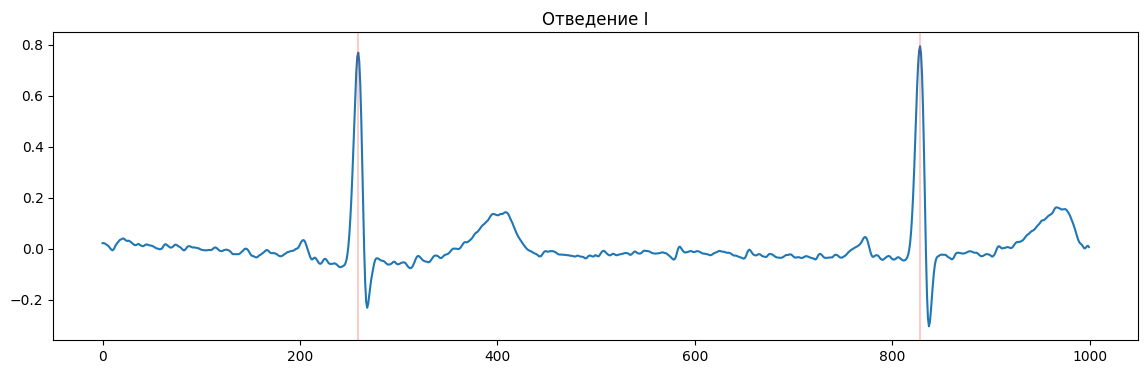

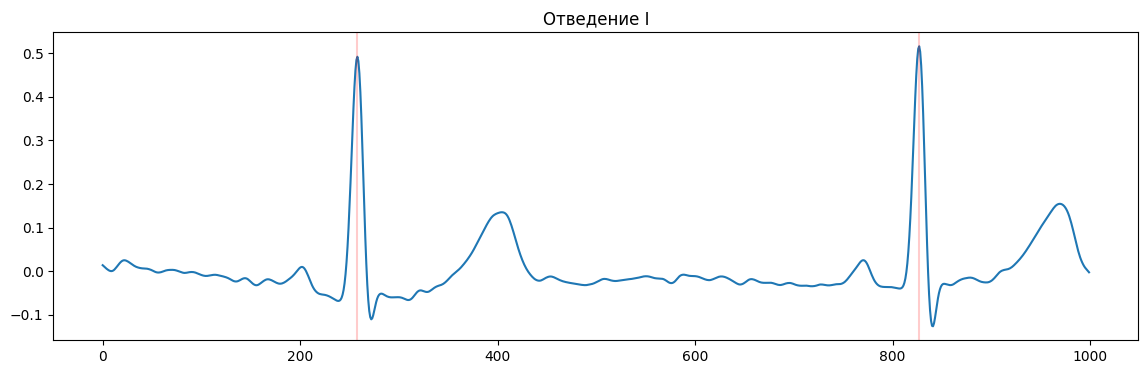

1


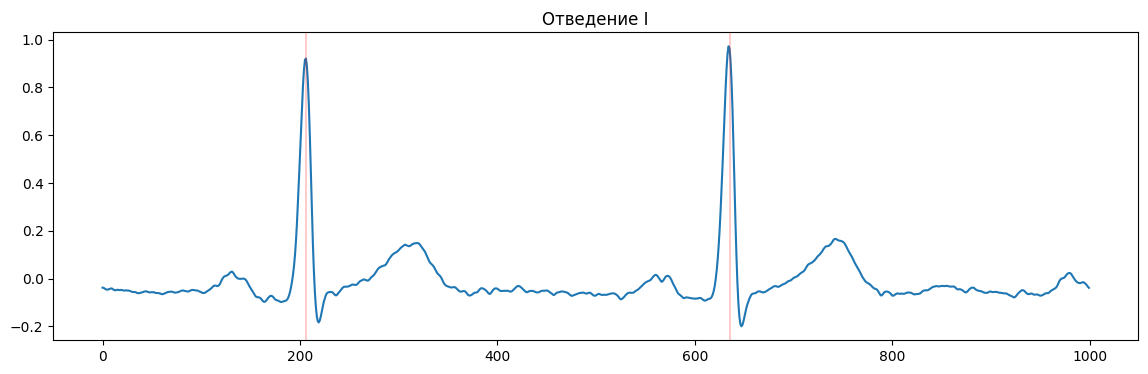

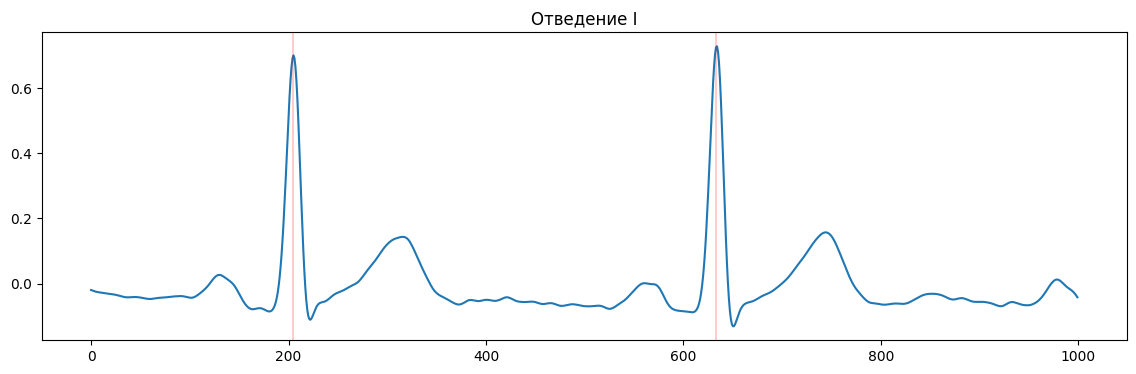

1


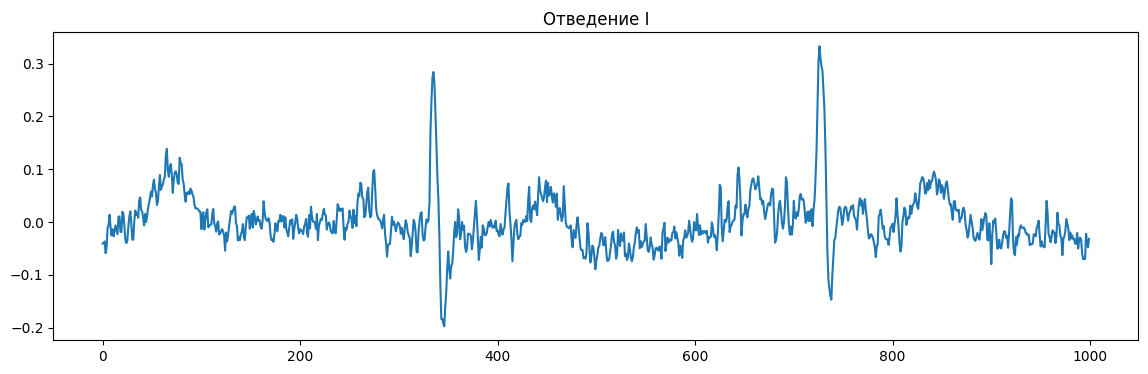

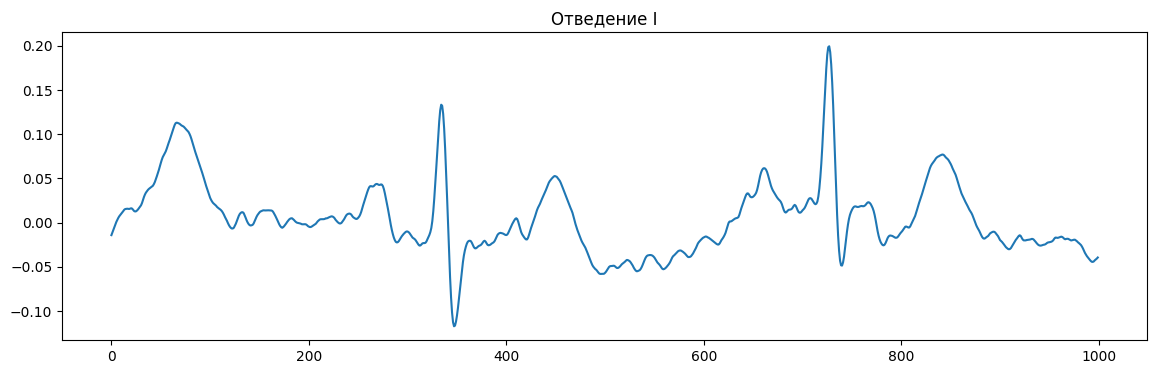

23


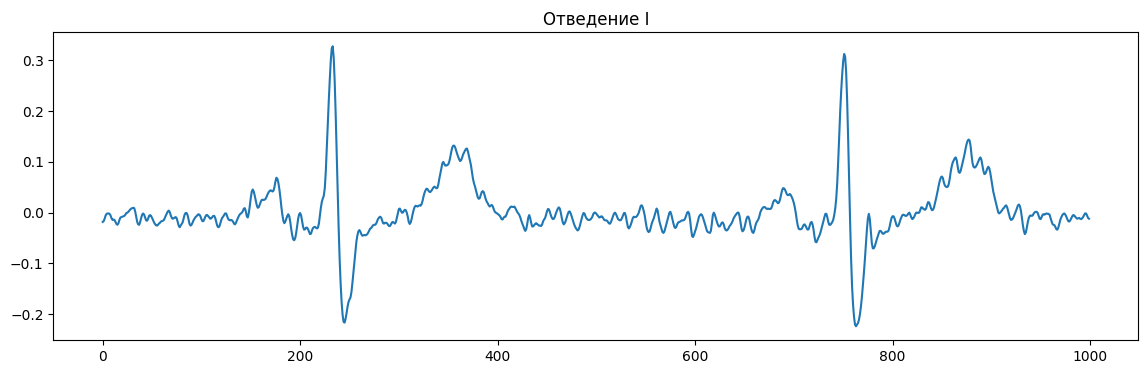

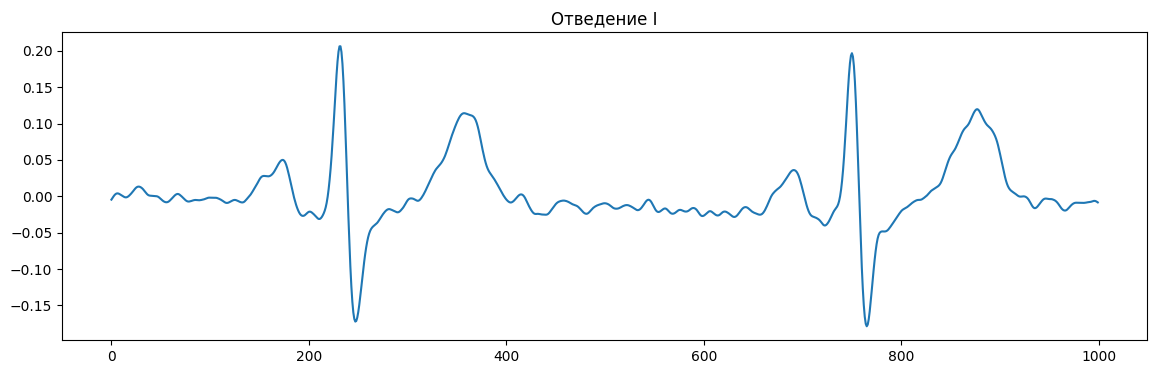

146


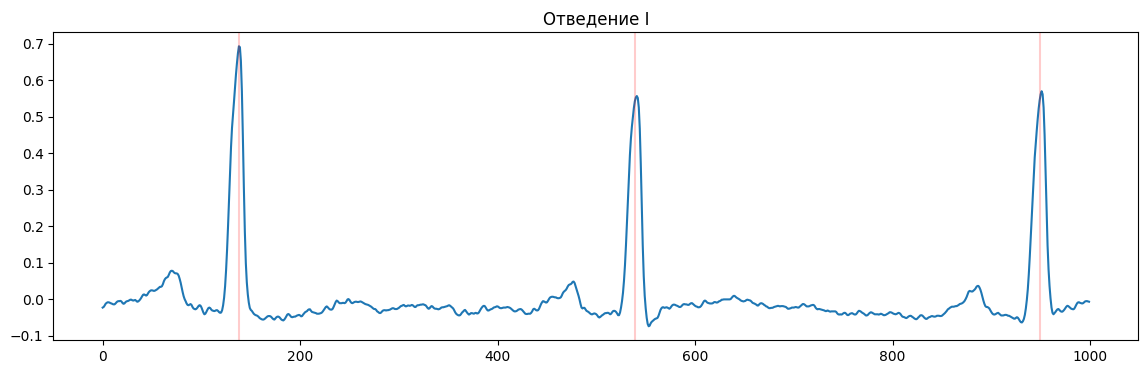

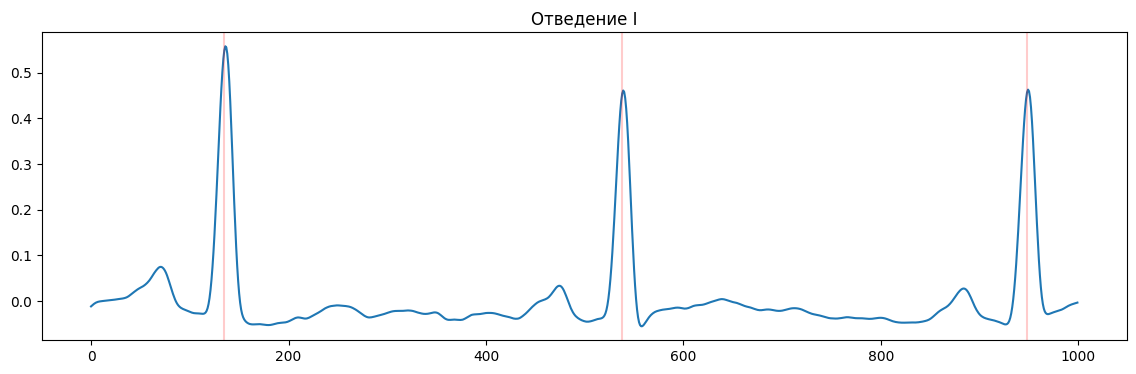

1


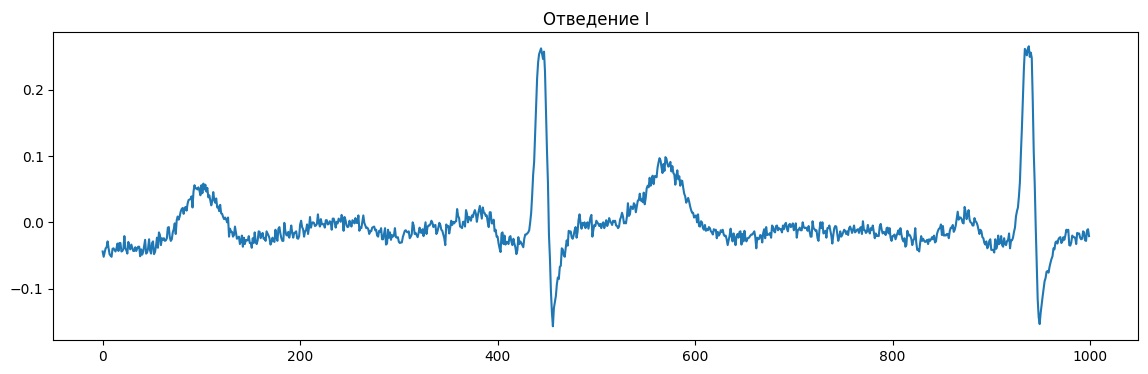

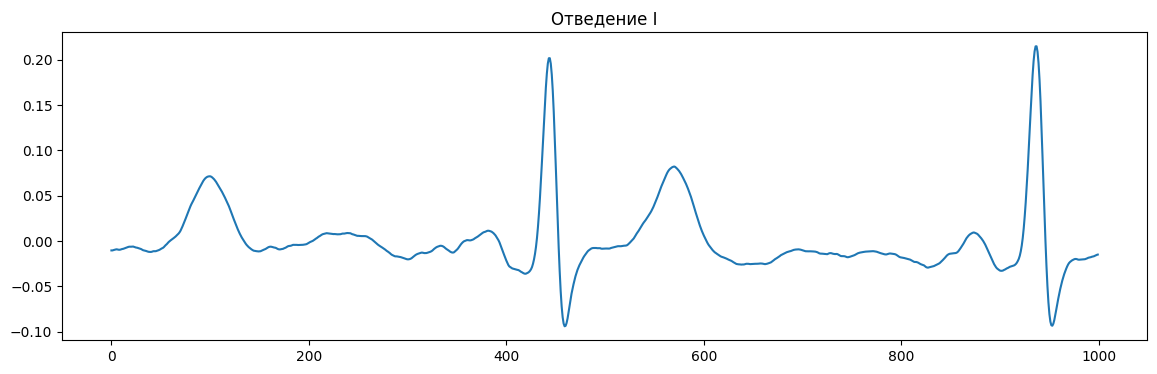

106


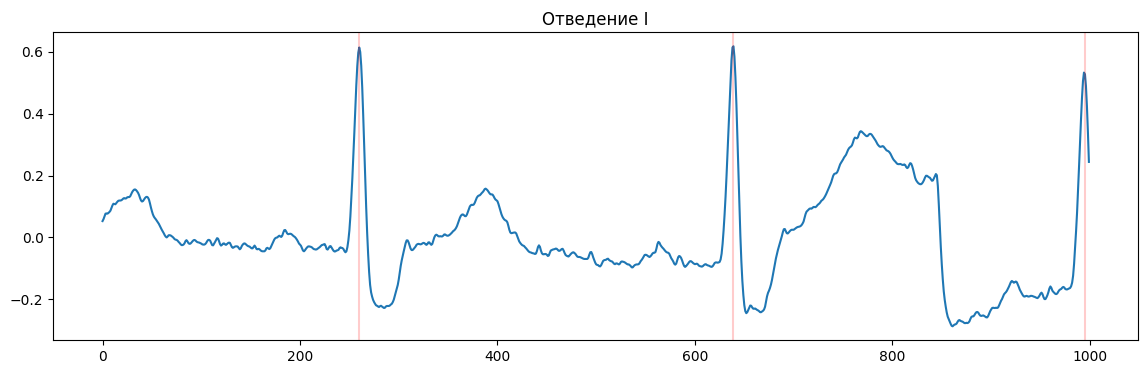

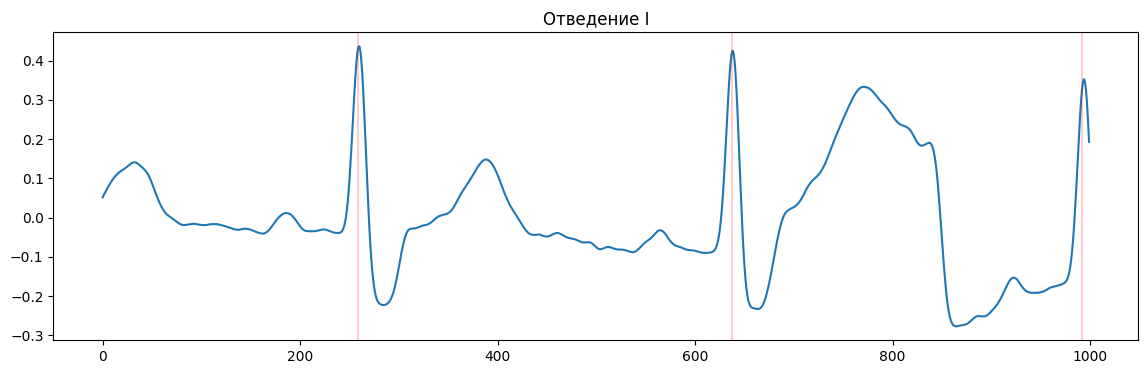

1


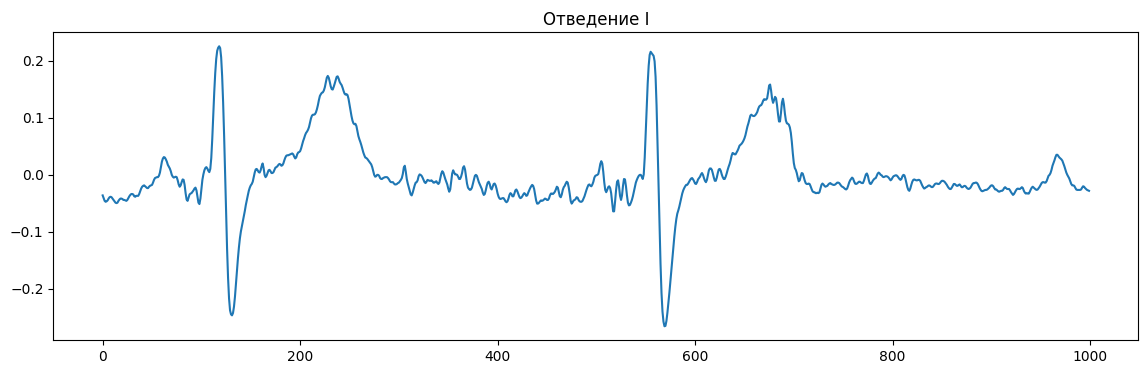

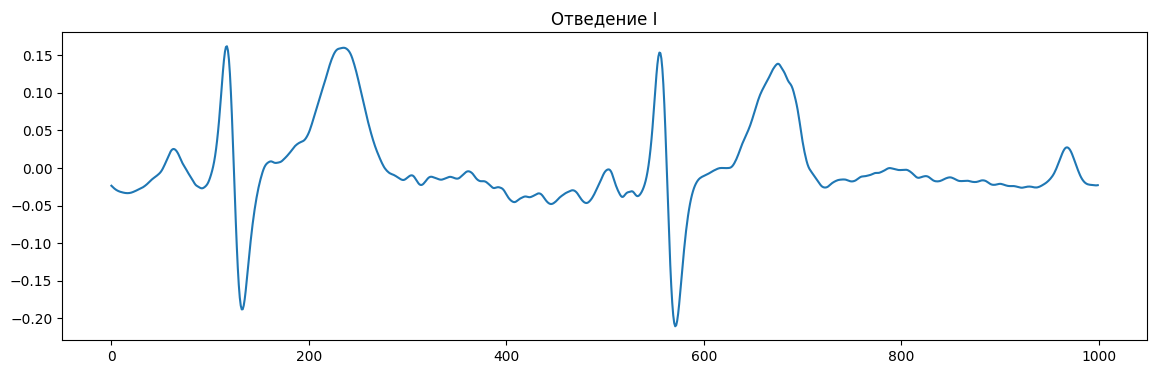

1


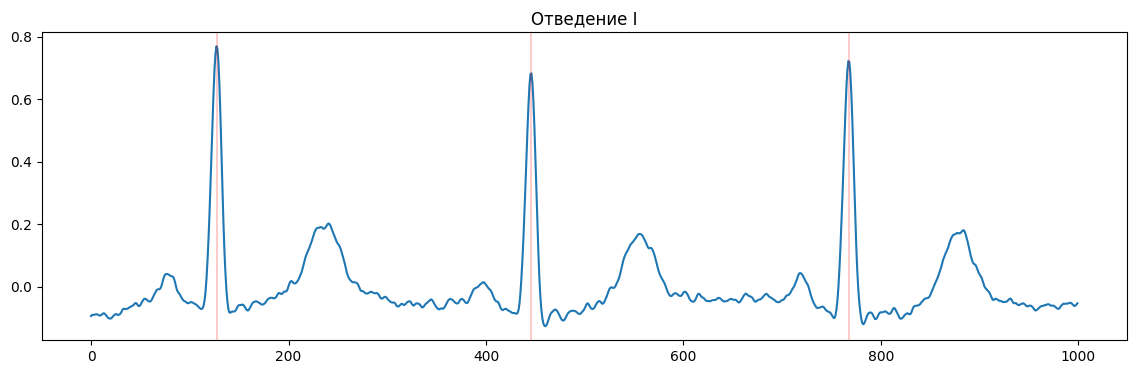

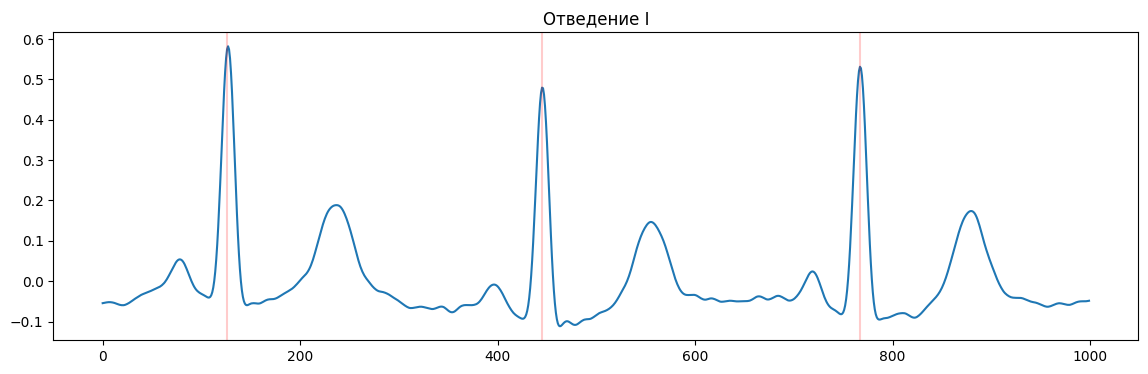

1


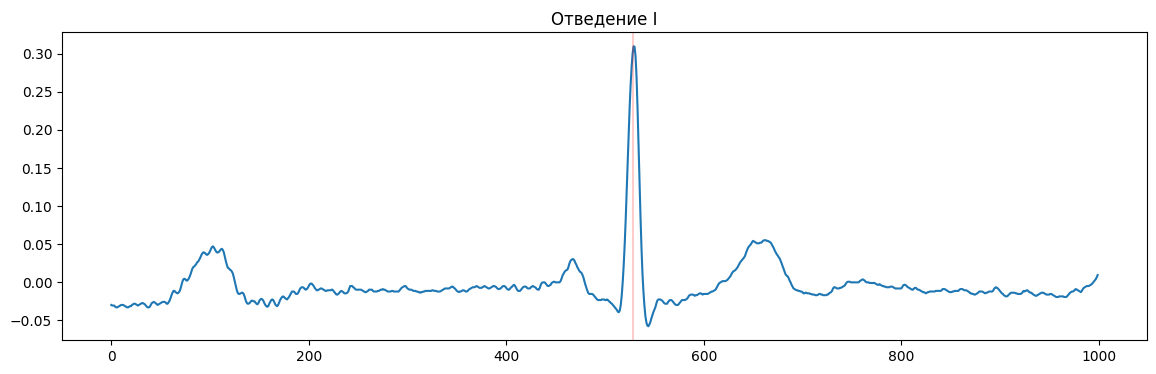

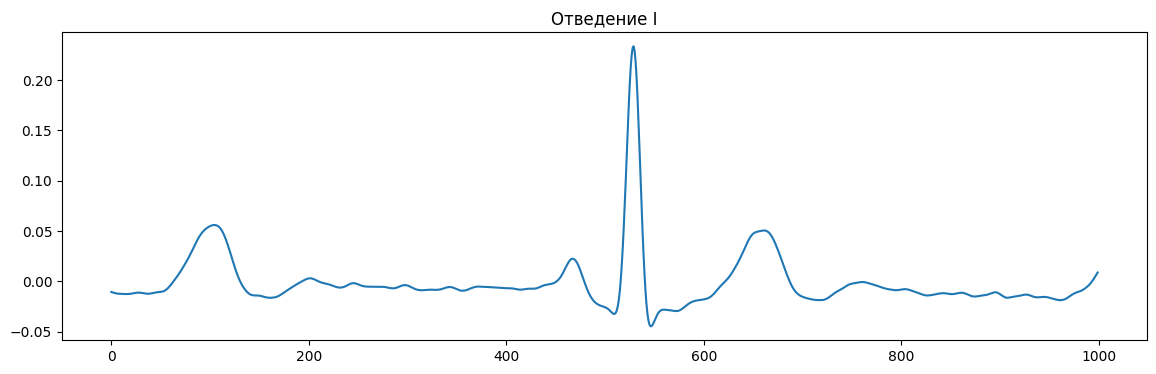

In [143]:
seq_len = 1000

for i in range(len(signals)):
    print(labels[i])
    
    p_peaks_0, heart_rate_0 = find_R_peaks(signals[i], seq_len=seq_len)
    visualize_channel_with_peaks(signals[i], p_peaks_0, seq_len=seq_len)

    p_peaks_0, heart_rate_0 = find_R_peaks(signals[i], to_filter=True, seq_len=seq_len)
    visualize_channel_with_peaks(signals[i], p_peaks_0, to_filter=True, seq_len=seq_len)

In [144]:
def BIC(x, y_true, k_max):
    n = len(y_true)
    b = []

    for k in range(1, k_max + 1):
        coefs_trended = np.polyfit(x, y_true, k)
        y_pred = np.polyval(coefs_trended, x)

        eps = np.sum((y_true - y_pred) * (y_true - y_pred)) / n

        b.append(n*np.log(eps) + k*np.log(n))

    plt.plot(np.arange(1, k_max + 1, 1), b, 'r.-')

    plt.plot([1, k_max], [min(b), min(b)], 'b-', alpha=0.5)
    plt.plot([np.argmin(b) + 1, np.argmin(b) + 1], [min(b), max(b)], 'b-', alpha=0.5)

    print(np.argmin(b))
    plt.show()

    return np.argmin(b)

16


C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_2492

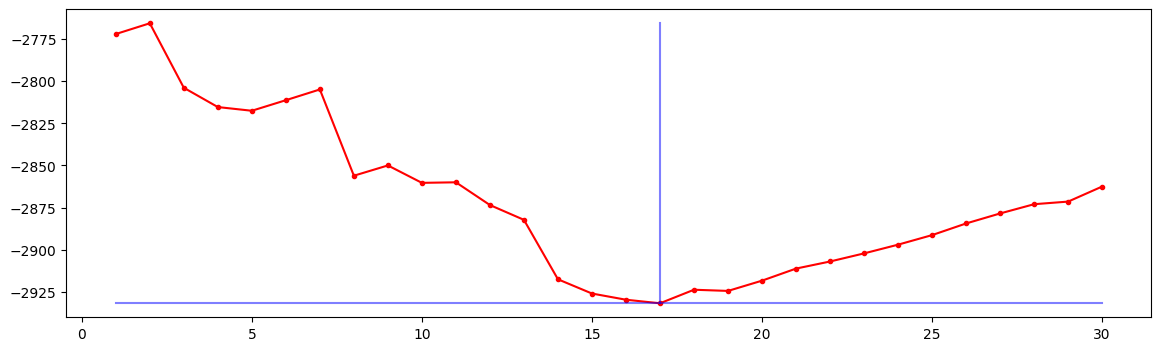

In [145]:
y1 = signals[6][0][0:600]
y1 = [float(i) for i in y1]

x1 = np.linspace(0, 1, len(y1))

k1 = BIC(x1, y1, 30)

In [146]:
def visualize_polyfit_data(signals, n, channel, start, end, k1):
    y1 = signals[n][channel][start:end]
    y1 = [float(i) for i in y1]
    x1 = np.linspace(0, len(y1) - 1, len(y1))

    coefs_trended1 = np.polyfit(x1, y1, k1)
    y_pred1 = np.polyval(coefs_trended1, x1)

    plt.plot(x1, y1, color='blue', alpha=0.5, label='Original')
    plt.plot(x1, y1 - y_pred1, color='red', alpha=0.5, label='Detrended')
    plt.axhline(0, label='Izoline (0)')
    plt.legend()
    plt.show()

def visualize_lin_reg_data(signals, n, channel, start, end, alpha=0.3):
    y1 = signals[n][channel][start:end]
    y1 = [float(i) for i in y1]
    x1 = np.linspace(0, len(y1) - 1, len(y1))

    x1_reshaped = np.reshape(x1, (len(x1), 1))

    model = LinearRegression()

    model.fit(x1_reshaped, y1)
    # print('Slope of the line is', model.coef_)
    # print('Intercept value is', model.intercept_)

    y_predicted = model.predict(x1_reshaped)

    plt.plot(x1, y_predicted, color='red', label='lin_reg')
    plt.plot(x1, y1, color='blue', label='original')
    plt.legend()
    plt.show()

    plt.axhline(0, color='red', label='Izoline (0)')
    plt.plot(x1, y1 - y_predicted, color='blue', label='lin_reged')
    plt.legend()
    plt.show()

    plt.plot(x1, y1, color='red', label='original', alpha=alpha)
    plt.plot(x1, y1 - y_predicted, color='blue', label='lin_reged', alpha=alpha)
    plt.legend()
    plt.show()

In [147]:
def find_R_peaks(signals, n, channel, sample_freq=500):
    _, info = nk.ecg_process(signals[n][channel], sampling_rate=sample_freq)
    return info['ECG_R_Peaks']

def segmentum_lin_reg_data(signals, n, channel, start, end):
    y1 = signals[n][channel][start:end]
    y1 = [float(i) for i in y1]
    x1 = np.linspace(start, end - 1, len(y1))

    x1_reshaped = np.reshape(x1, (len(x1), 1))

    model = LinearRegression()

    model.fit(x1_reshaped, y1)

    y_predicted = model.predict(x1_reshaped)
    
    return x1, y1, y_predicted

def find_lin_peaks(signals, n, channel, R_peaks):
    # TODO: нахождение линейных участков
    return R_peaks

In [148]:
def lin_req_R_peaks(signals, n, channel):
    R_peaks = find_R_peaks(signals, n, channel)

    lin_peaks = find_lin_peaks(signals, n, channel, R_peaks)

    xs = []
    ys = []
    y_preds = []

    for i in range(len(lin_peaks) - 1):
        # visualize_lin_reg_data(signals, n, channel, lin_peaks[i], lin_peaks[i + 1])

        # Затычка, чтобы не брать краевые значения
        # visualize_lin_reg_data(signals, n, channel, lin_peaks[i] + 30, lin_peaks[i + 1] - 30)
        x, y, y_pred = segmentum_lin_reg_data(signals, n, channel, lin_peaks[i], lin_peaks[i + 1])
        
        xs.append(x)
        ys.append(y)
        y_preds.append(y_pred)
    
    y_res = signals[n][channel]
    
    for i in range(len(xs)):
        plt.plot(xs[i], ys[i], color='blue')
        plt.plot(xs[i], y_preds[i], color='red')

        for j in range(len(xs[i])):
            y_res[int(xs[i][j])] = ys[i][j] - y_preds[i][j]
    
    plt.show()

    plt.plot(y_res[R_peaks[0]:R_peaks[-1]], color='blue')
    plt.axhline(0, color='red')
    
    plt.show()

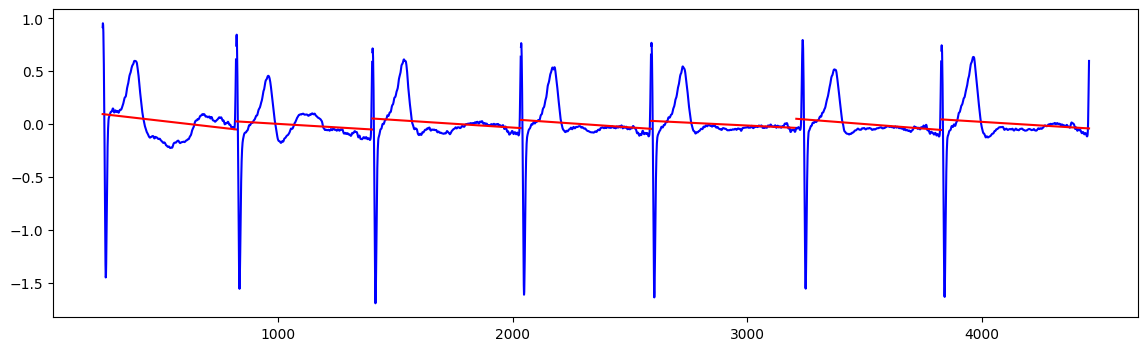

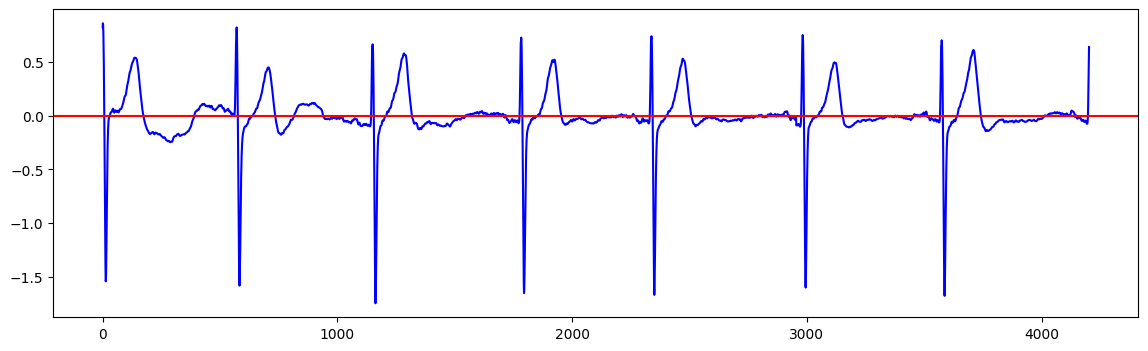

In [149]:
lin_req_R_peaks(signals, 0, 7)

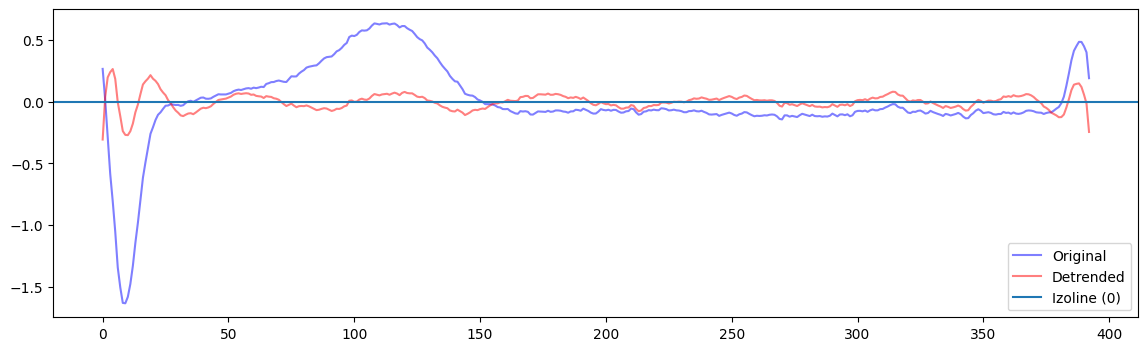

In [150]:
visualize_polyfit_data(signals, 2, 7, 334, 727, 16)

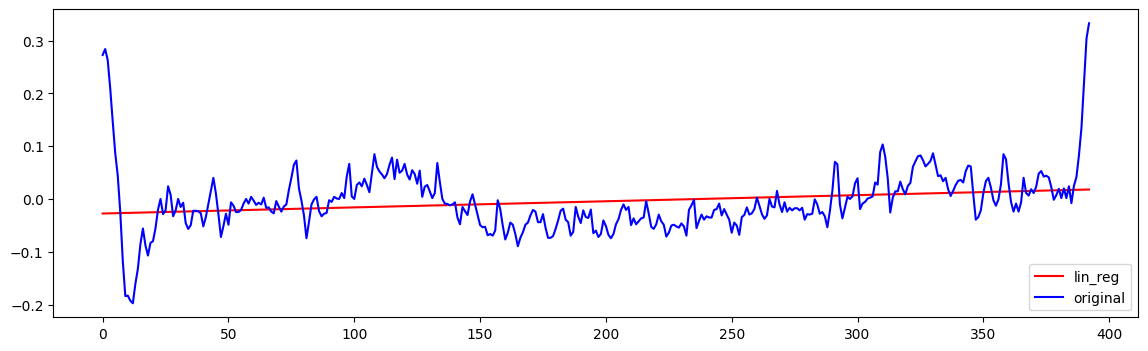

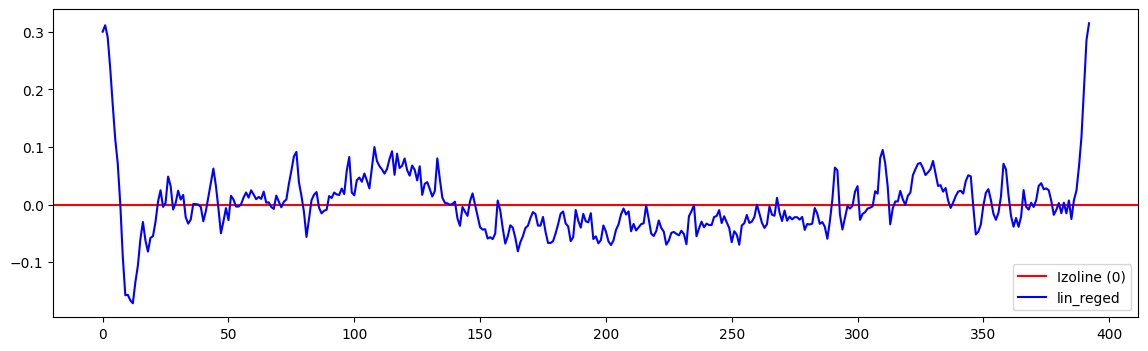

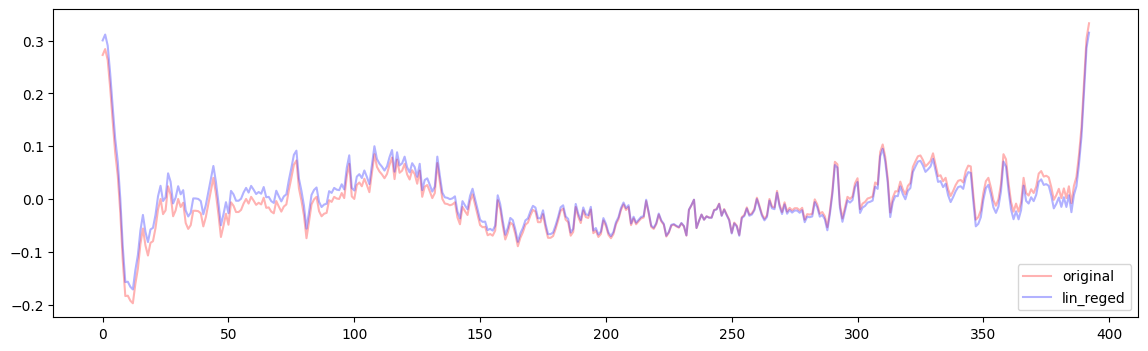

In [151]:
visualize_lin_reg_data(signals, 2, 0, 334, 727)

In [152]:
def slide_window(signals, n, channel, window_len=5):
    signal = signals[n][channel]
    

In [153]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def visualize_window(signals, n, channel, window_size=5, threshold=0.2):
    data = signals[n][channel]
    data_smooth = moving_average(data, window_size=window_size)

    # Производная
    derivative = np.diff(data_smooth)

    # Начало поднятия
    rise_starts = np.where(derivative > threshold)[0]
    # Начало опускания
    fall_starts = np.where(derivative < -threshold)[0]

    # Визуализация
    plt.plot(data, label="Несглаженный сигнал")
    plt.show()

    plt.plot(data_smooth, label="Сглаженный сигнал")
    plt.plot(rise_starts, data_smooth[rise_starts], "go", label="Начало поднятия")
    plt.plot(fall_starts, data_smooth[fall_starts], "ro", label="Начало опускания")
    plt.legend()
    plt.show()

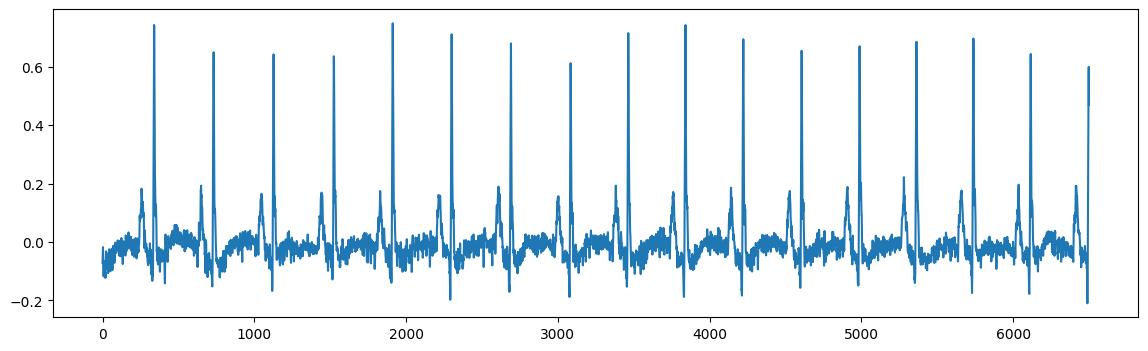

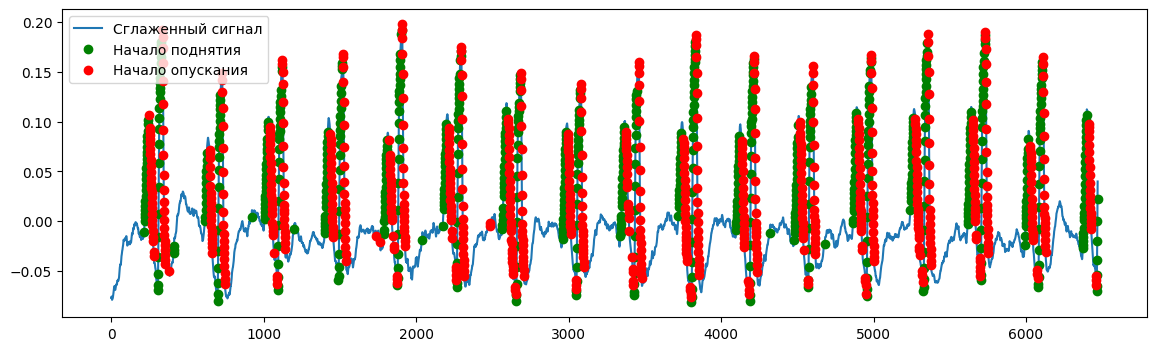

In [154]:
visualize_window(signals, 2, 2, 30, 0.025/8)

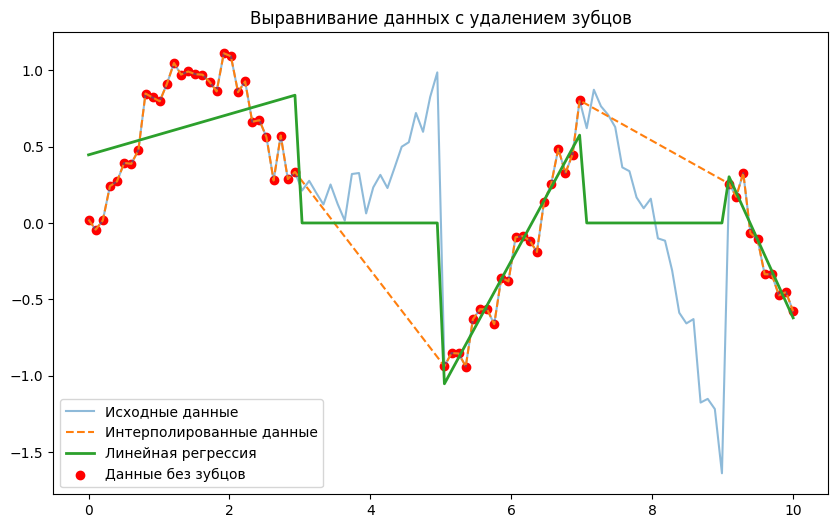

In [155]:
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.1 * np.random.normal(size=100)

# Искусственный зубец
y[30:50] += np.linspace(0, 2, 20)  # Поднятие
y[70:90] -= np.linspace(0, 2, 20)  # Опускание

# Найдем зубцы (вручную зададим их начало и конец)
tooth_ranges = [(30, 50), (70, 90)]

# Удалим зубцы
mask = np.ones_like(y, dtype=bool)
for start, end in tooth_ranges:
    mask[start:end] = False

x_clean = x[mask]
y_clean = y[mask]

# Линейная интерполяция для заполнения пропущенных данных
f_interp = interpolate.interp1d(x_clean, y_clean, kind='linear', fill_value="extrapolate")
y_interp = f_interp(x)

# Построим линейную регрессию для каждого сегмента
def fit_linear_segment(x_segment, y_segment):
    model = LinearRegression()
    model.fit(x_segment.reshape(-1, 1), y_segment)
    return model.predict(x_segment.reshape(-1, 1))

# Применим линейную регрессию к каждому сегменту
y_fitted = np.zeros_like(y)
for i in range(len(tooth_ranges) + 1):
    if i == 0:
        start, end = 0, tooth_ranges[i][0]
    elif i == len(tooth_ranges):
        start, end = tooth_ranges[i-1][1], len(x)
    else:
        start, end = tooth_ranges[i-1][1], tooth_ranges[i][0]
    
    x_segment = x[start:end]
    y_segment = y_interp[start:end]
    y_fitted[start:end] = fit_linear_segment(x_segment, y_segment)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Исходные данные", alpha=0.5)
plt.plot(x, y_interp, label="Интерполированные данные", linestyle="--")
plt.plot(x, y_fitted, label="Линейная регрессия", linewidth=2)
plt.scatter(x_clean, y_clean, color="red", label="Данные без зубцов")
plt.legend()
plt.title("Выравнивание данных с удалением зубцов")
plt.show()

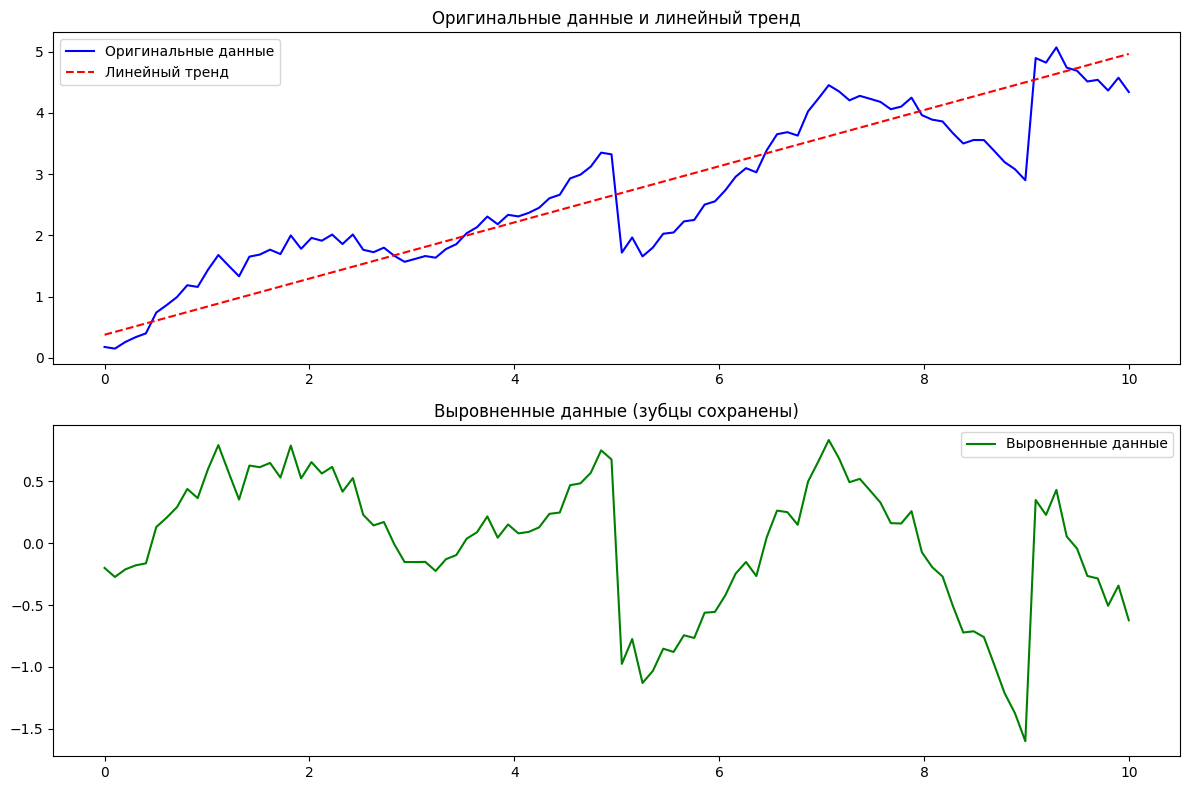

In [156]:
x = np.linspace(0, 10, 100)
y = 0.5 * x + np.sin(x) + 0.1 * np.random.normal(size=100)  # Линейный тренд + зубцы + шум

# Добавим искусственные зубцы
y[30:50] += np.linspace(0, 2, 20)  # Поднятие
y[70:90] -= np.linspace(0, 2, 20)  # Опускание

# Найдем зубцы (вручную зададим их начало и конец)
tooth_ranges = [(30, 50), (70, 90)]

# Удалим зубцы
mask = np.ones_like(y, dtype=bool)
for start, end in tooth_ranges:
    mask[start:end] = False

x_clean = x[mask]
y_clean = y[mask]

# Линейная интерполяция для заполнения пропущенных данных
f_interp = interpolate.interp1d(x_clean, y_clean, kind='linear', fill_value="extrapolate")
y_interp = f_interp(x)

# Построим линейную регрессию на интерполированных данных
model = LinearRegression()
model.fit(x.reshape(-1, 1), y_interp)
y_trend = model.predict(x.reshape(-1, 1))

# Вычтем линейный тренд из оригинальных данных
y_flattened = y - y_trend

# Визуализация
plt.figure(figsize=(12, 8))

# Оригинальные данные
plt.subplot(2, 1, 1)
plt.plot(x, y, label="Оригинальные данные", color="blue")
plt.plot(x, y_trend, label="Линейный тренд", color="red", linestyle="--")
plt.title("Оригинальные данные и линейный тренд")
plt.legend()

# Выровненные данные
plt.subplot(2, 1, 2)
plt.plot(x, y_flattened, label="Выровненные данные", color="green")
plt.title("Выровненные данные (зубцы сохранены)")
plt.legend()

plt.tight_layout()
plt.show()

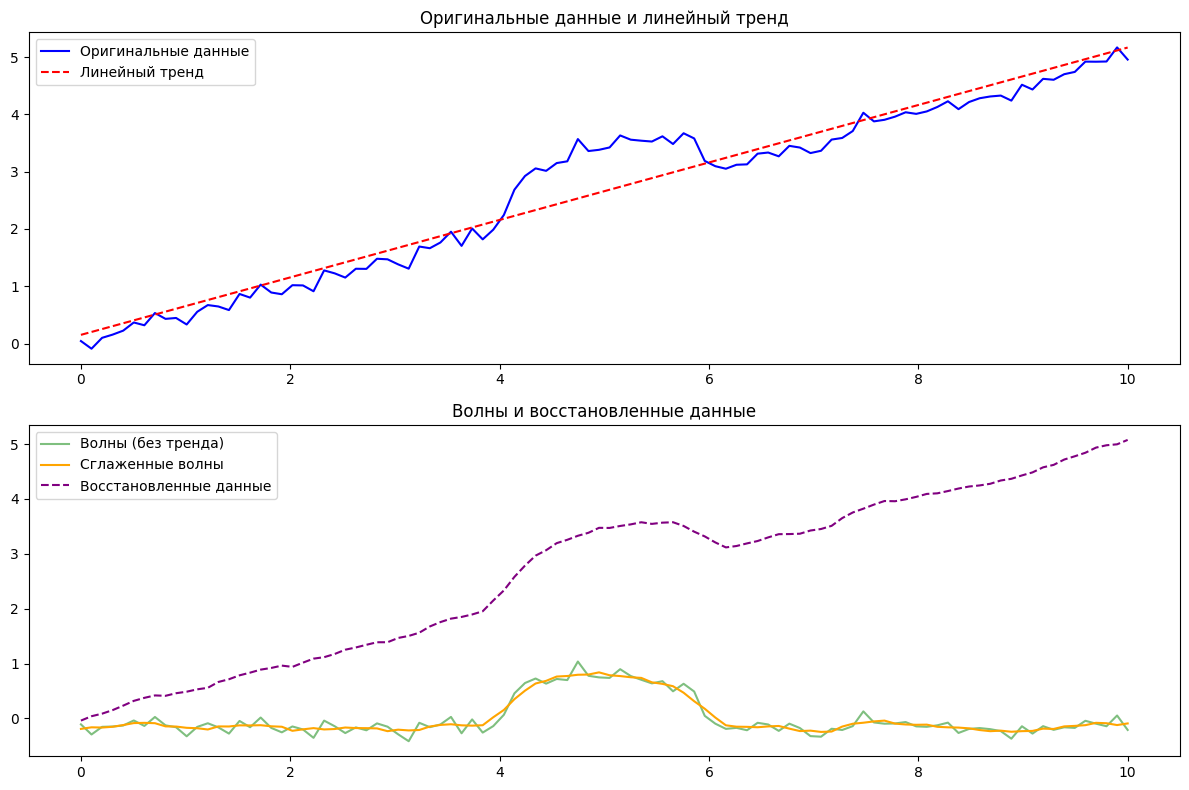

In [157]:
x = np.linspace(0, 10, 100)
y = 0.5 * x + np.sqrt(np.maximum(0, 1 - (x - 5)**2))  # Линейный тренд + волна (полукруг)
y += 0.1 * np.random.normal(size=100)  # Добавим шум

# Найдем линейный тренд
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_trend = model.predict(x.reshape(-1, 1))

# Удалим тренд, чтобы получить волны
y_waves = y - y_trend

# Обработаем волны (например, сгладим их)
y_waves_smoothed = uniform_filter1d(y_waves, size=5)  # Скользящее среднее

# Восстановим данные, добавив обработанные волны к тренду
y_restored = y_trend + y_waves_smoothed

# Визуализация
plt.figure(figsize=(12, 8))

# Оригинальные данные и тренд
plt.subplot(2, 1, 1)
plt.plot(x, y, label="Оригинальные данные", color="blue")
plt.plot(x, y_trend, label="Линейный тренд", color="red", linestyle="--")
plt.title("Оригинальные данные и линейный тренд")
plt.legend()

# Волны и восстановленные данные
plt.subplot(2, 1, 2)
plt.plot(x, y_waves, label="Волны (без тренда)", color="green", alpha=0.5)
plt.plot(x, y_waves_smoothed, label="Сглаженные волны", color="orange")
plt.plot(x, y_restored, label="Восстановленные данные", color="purple", linestyle="--")
plt.title("Волны и восстановленные данные")
plt.legend()

plt.tight_layout()
plt.show()

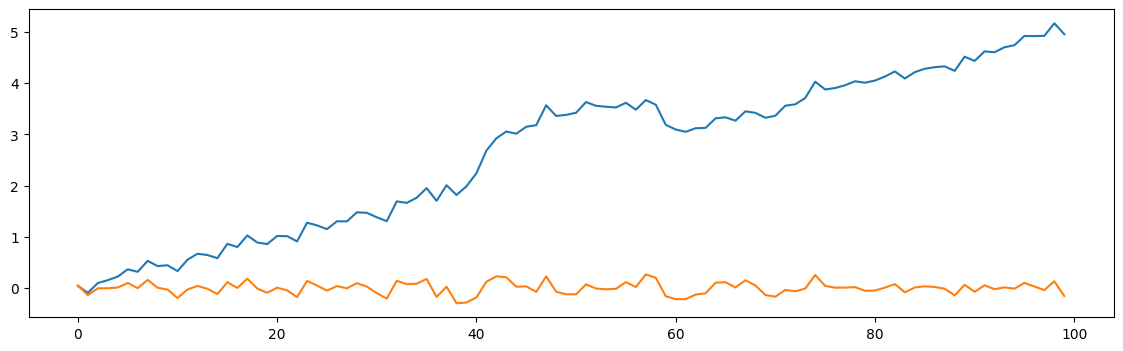

In [158]:
# Применяем фильтр Савицкого-Голея для выделения тренда
window_size = 21  # Размер окна (должен быть нечетным)
poly_order = 2    # Порядок полинома
y_trend = savgol_filter(y, window_size, poly_order)

# Удаляем тренд, чтобы получить волны
y_waves = y - y_trend

plt.plot(y)
plt.plot(y_waves)
plt.show()

In [159]:
def savgol(signals, n, channel, window_size=21, poly_order=2):
    data = signals[n][channel]
    window_size = window_size           # Размер окна (должен быть нечетным)
    poly_order = poly_order             # Порядок полинома
    y_trend = savgol_filter(data, window_size, poly_order)

    y_waves = data - y_trend

    plt.plot(data)
    plt.plot(y_waves)
    plt.show()

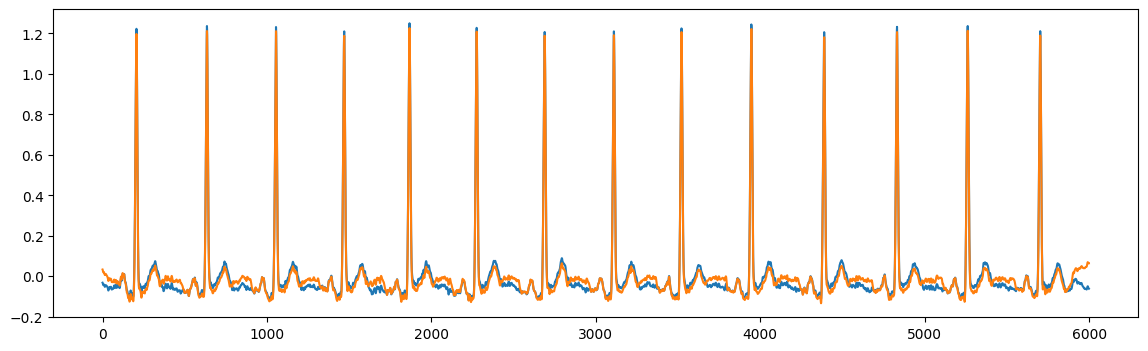

In [160]:
savgol(signals, 1, 1, 301, 1)

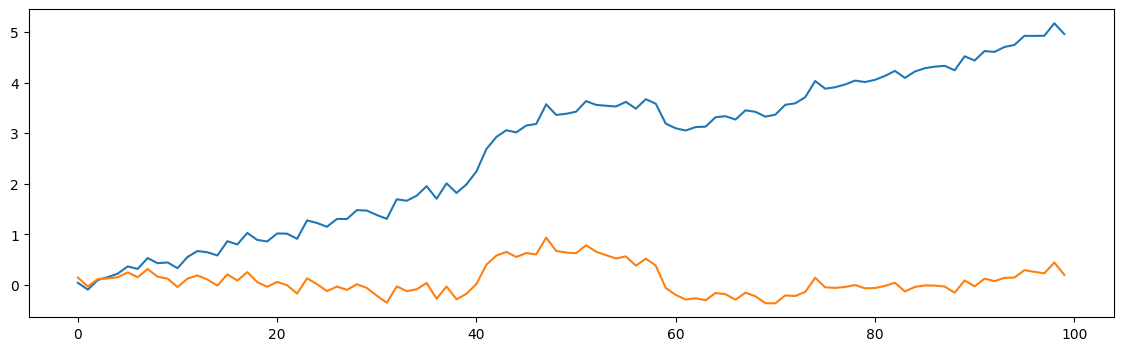

In [161]:
from scipy.interpolate import UnivariateSpline

# Находим ключевые точки тренда (например, минимумы волн)
minima_indices = np.where((np.roll(y, 1) > y) & (np.roll(y, -1) > y))[0]
x_trend = x[minima_indices]
y_trend_points = y[minima_indices]

# Строим сплайн по ключевым точкам
spline = UnivariateSpline(x_trend, y_trend_points, s=2)  # s=0 — без сглаживания
y_trend = spline(x)

# Удаляем тренд, чтобы получить волны
y_waves = y - y_trend

plt.plot(y)
plt.plot(y_waves)
plt.show()

In [162]:
def spline(signals, n, channel, window_size=21, poly_order=2):
    # Находим ключевые точки тренда (например, минимумы волн)
    y = signals[n][channel]
    minima_indices = np.where((np.roll(y, 1) > y) & (np.roll(y, -1) > y))[0]
    x_trend = x[minima_indices]
    y_trend_points = y[minima_indices]

    # Строим сплайн по ключевым точкам
    spline = UnivariateSpline(x_trend, y_trend_points, s=10)  # s=0 — без сглаживания
    y_trend = spline(x)

    # Удаляем тренд, чтобы получить волны
    y_waves = y - y_trend

    plt.plot(y)
    plt.plot(y_waves)
    plt.show()

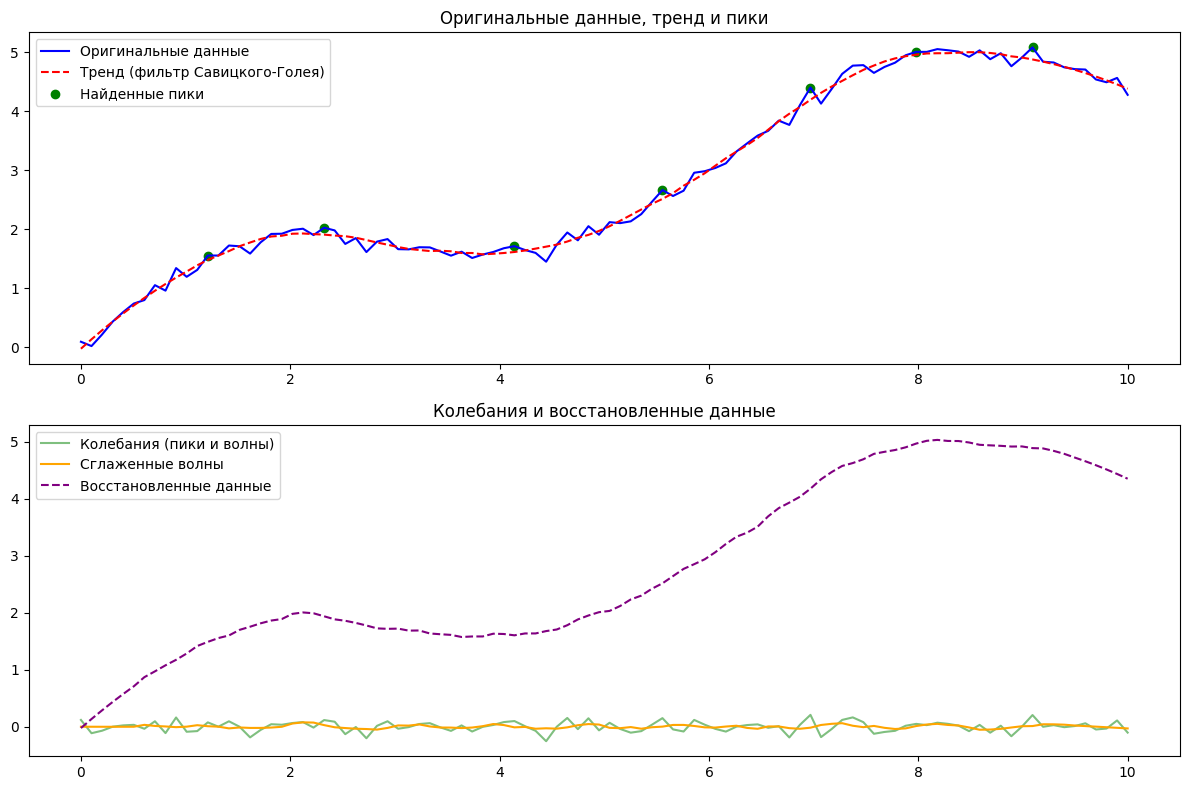

In [163]:
x = np.linspace(0, 10, 100)
y = 0.5 * x + np.sin(x) + 0.5 * np.exp(-0.5 * (x - 5)**2)   # Линейный тренд + волна + пик
y += 0.1 * np.random.normal(size=100)                       # Добавим шум

# 1. Пики
peaks, _ = find_peaks(y, height=1, distance=10)

# 2. Фильтр Савицкого-Голея
y_trend = savgol_filter(y, window_length=21, polyorder=2)

# 3. Удаление тренда
y_fluctuations = y - y_trend

# 4. Сглаживание волн
y_waves_smoothed = savgol_filter(y_fluctuations, window_length=11, polyorder=2)

# 5. Восстановление пиков
y_restored = y_trend + y_waves_smoothed

# Визуализация
plt.figure(figsize=(12, 8))

# Оригинальные данные и тренд
plt.subplot(2, 1, 1)
plt.plot(x, y, label="Оригинальные данные", color="blue")
plt.plot(x, y_trend, label="Тренд (фильтр Савицкого-Голея)", color="red", linestyle="--")
plt.scatter(x[peaks], y[peaks], color="green", label="Найденные пики")
plt.title("Оригинальные данные, тренд и пики")
plt.legend()

# Колебания и восстановленные данные
plt.subplot(2, 1, 2)
plt.plot(x, y_fluctuations, label="Колебания (пики и волны)", color="green", alpha=0.5)
plt.plot(x, y_waves_smoothed, label="Сглаженные волны", color="orange")
plt.plot(x, y_restored, label="Восстановленные данные", color="purple", linestyle="--")
plt.title("Колебания и восстановленные данные")
plt.legend()

plt.tight_layout()
plt.show()

In [164]:
def ultra_filter(signals, n, channel):
    y = signals[n][channel]
    x = np.linspace(0, len(y) - 1, len(y))

    # 1. Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)  # Настройте параметры под ваши данные
    peaks = peaks[peaks < len(y)]

    # 2. Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # 3. Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # 4. Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # 5. Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed

    # Визуализация
    plt.figure(figsize=(12, 8))

    # Оригинальные данные и тренд
    plt.subplot(2, 1, 1)
    plt.plot(y, label="Оригинальные данные", color="blue")
    plt.plot(y_trend, label="Тренд (фильтр Савицкого-Голея)", color="red", linestyle="--")
    plt.scatter(x[peaks], y[peaks], color="green", label="Найденные пики")
    plt.title("Оригинальные данные, тренд и пики")
    plt.legend()

    # Колебания и восстановленные данные
    plt.subplot(2, 1, 2)
    plt.plot(y_fluctuations, label="Колебания (пики и волны)", color="green", alpha=0.5)
    plt.plot(y_waves_smoothed, label="Сглаженные волны", color="orange")
    plt.plot(y_restored, label="Восстановленные данные", color="purple", linestyle="--")
    plt.title("Колебания и восстановленные данные")
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.plot(y)
    plt.plot(y_restored)
    plt.show()

    plt.figure(figsize=(12, 10))
    # Сравним с использованием neurokit
    plt.plot(y + 1, alpha=0.3)
    y_nk = nk.ecg_clean(y)
    plt.plot(y_nk, alpha=0.3)
    plt.plot(y_restored - 1, alpha=0.3)
    plt.show()

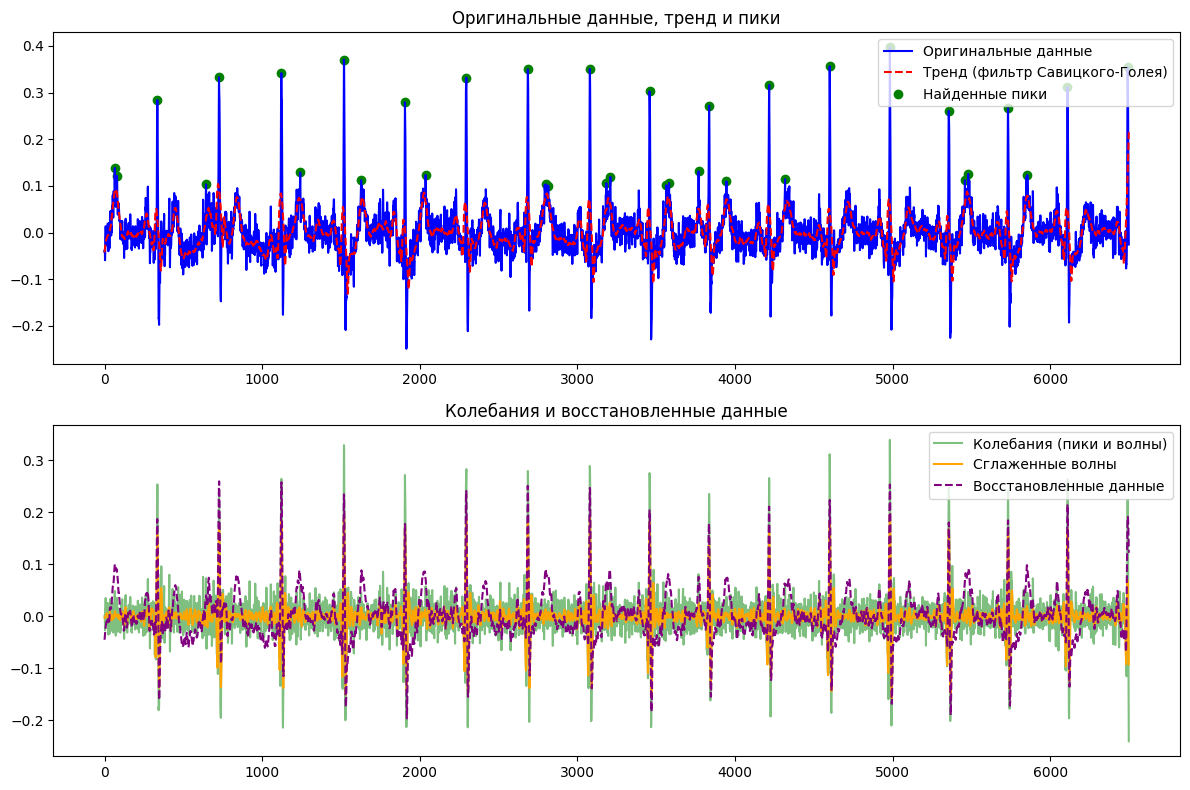

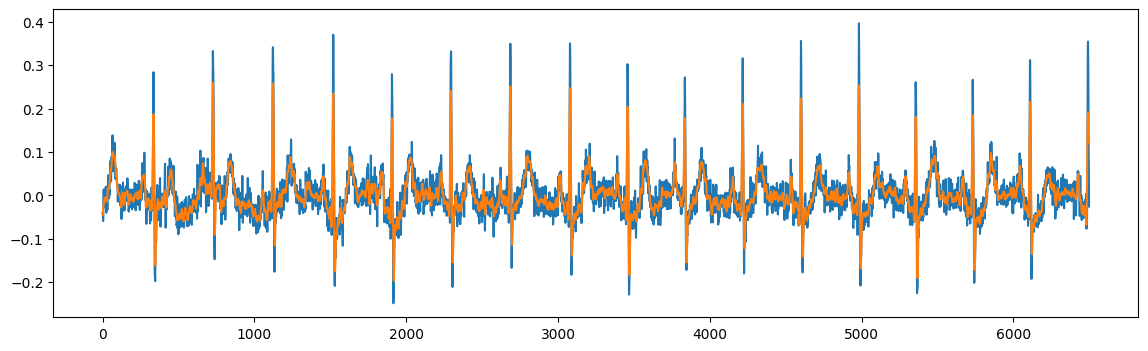

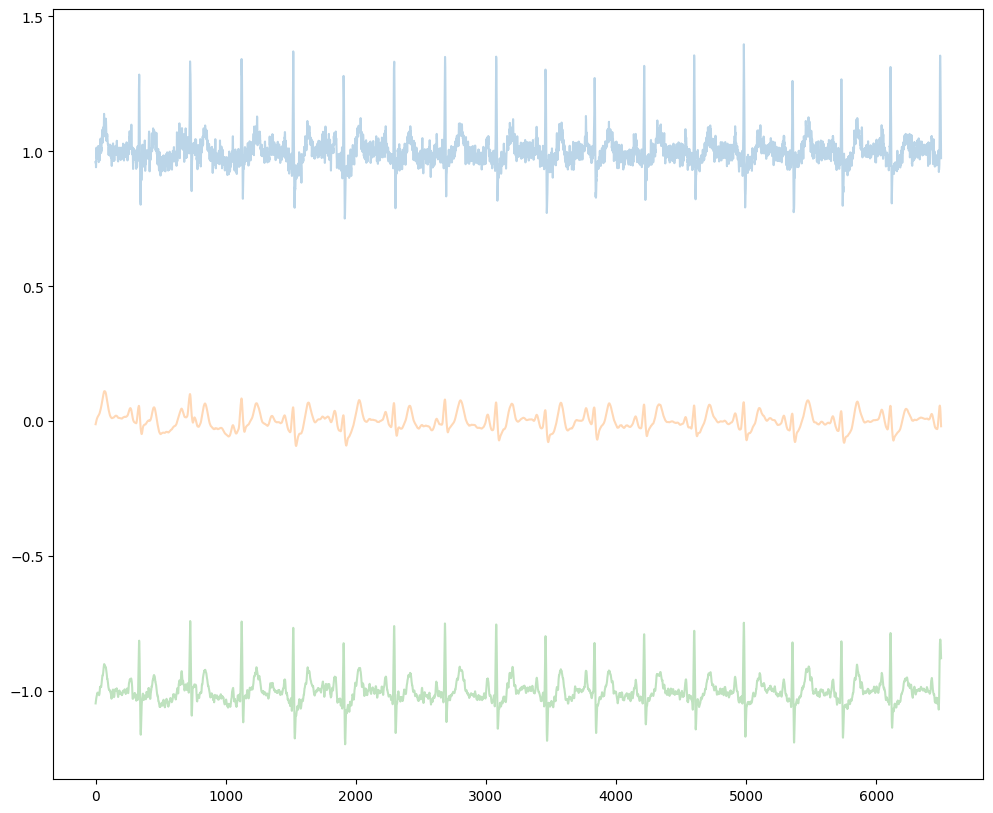

In [165]:
ultra_filter(signals, 2, 0)

Вывод: использовать ultra_filter лучше для таких шумных данных

Протестируем на +- обычных данных:

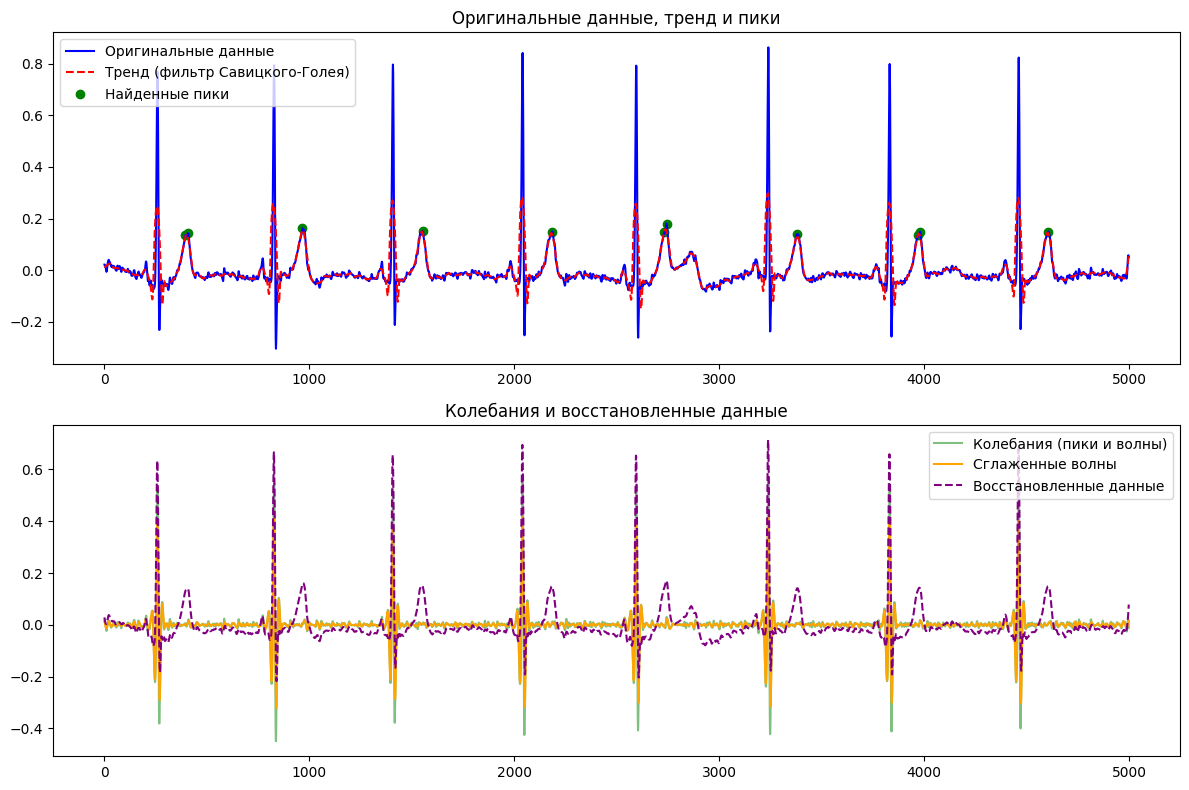

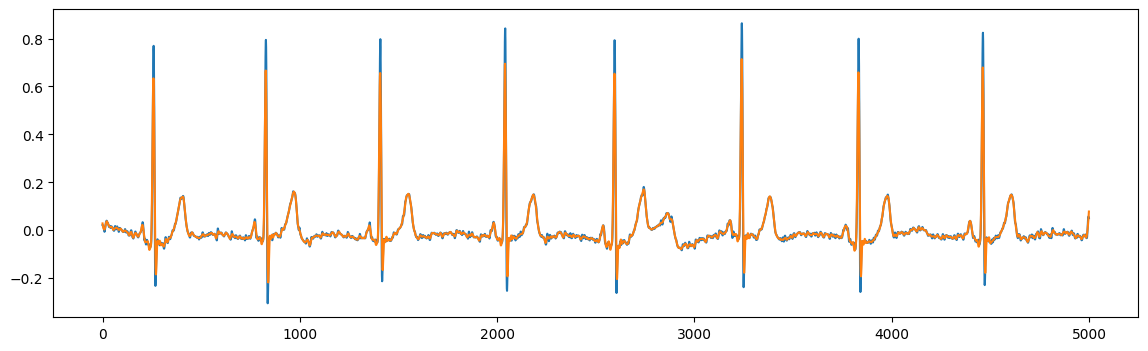

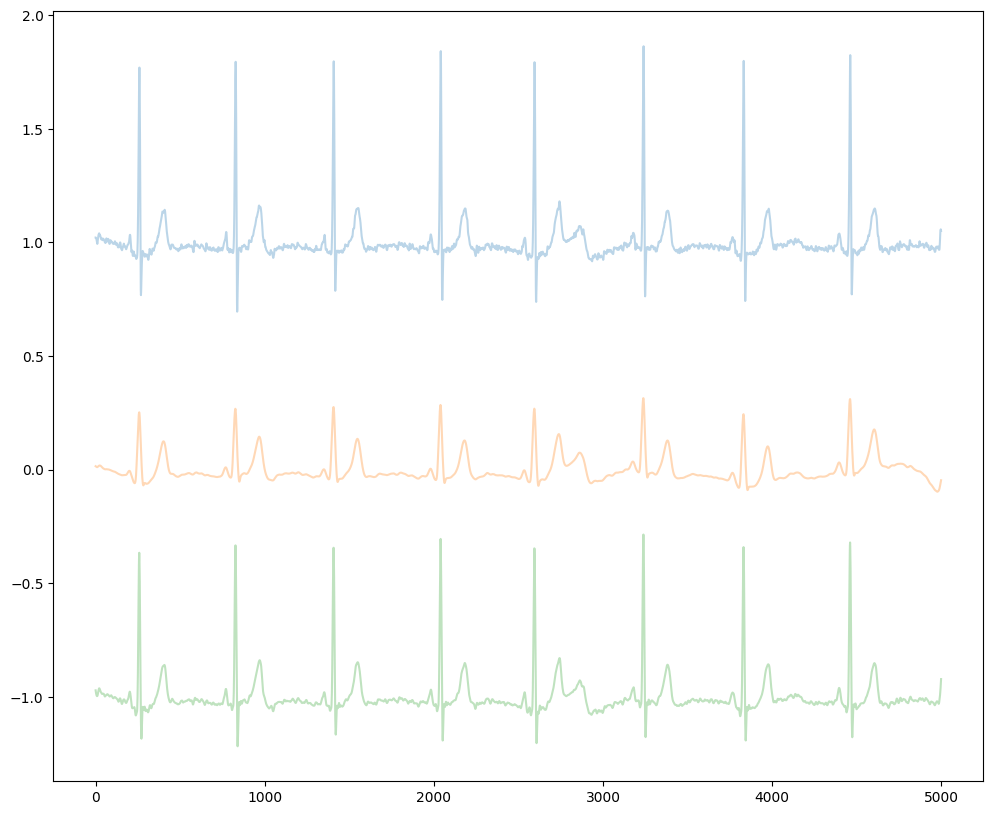

In [166]:
ultra_filter(signals, 0, 0)

Раз уж снижение шума идёт хорошо, можно использовать поиск пиков и интерполяцию